In [1]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

import cv2
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#%% --- realWsum,  AVIRIS_d ---  (data_preporation_for_elit_2023)
train_data_path_1 = '/kaggle/input/im-registration-accur-estimation/train__wSum__AVIRIS_d__4980p.csv'
train_1 = pd.read_csv(train_data_path_1)

test_data_path_1 = '/kaggle/input/im-registration-accur-estimation/test__wSum__AVIRIS_d__879p.csv'
test_1 = pd.read_csv(test_data_path_1)



valid_data_path_1 = '/kaggle/input/im-registration-accur-estimation/valid__wSum__AVIRIS_d__1996p.csv'
valid_1 = pd.read_csv(valid_data_path_1)



In [3]:
train = train_1.copy()
test = test_1.copy()

valid = valid_1.copy()

select_par = 'P'    # 'x', 'y', 'sc', 'rot', 'P'

# is_P_thresh = True

In [4]:
train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ci_s', 'ri_s', 'snr', 'Rz_ri',
       'shift_x_ideal', 'shift_y_ideal', 'scale_ideal', 'rot_ideal',
       'rmse_x__kp', 'rmse_y__kp', 'rmse_sc__kp', 'rmse_rot__kp',
       'rmse_x__ncc', 'rmse_y__ncc', 'rmse_sc__ncc', 'rmse_rot__ncc', 'P__kp',
       'P__ncc', 'subpix_x', 'subpix_y', 'scale', 'rot', 'mdx', 'mdy', 'widx',
       'widy', 'CRLB_x', 'CRLB_y', 'CRLB_sc', 'CRLB_rot', 'quasi_CRLB_x',
       'quasi_CRLB_y', 'quasi_CRLB_sc', 'quasi_CRLB_rot', 'p_Kybic', 'Kybic_x',
       'Kybic_y', 'Kybic_sc', 'Kybic_rot', 'Kybic_x_y', 'Kybic_x_sc',
       'Kybic_x_rot', 'Kybic_y_sc', 'Kybic_y_rot', 'Kybic_sc_rot'],
      dtype='object')

In [5]:
train.tail()

,Unnamed: 0.1,Unnamed: 0,ci_s,ri_s,snr,Rz_ri,shift_x_ideal,shift_y_ideal,scale_ideal,rot_ideal,...,Kybic_x,Kybic_y,Kybic_sc,Kybic_rot,Kybic_x_y,Kybic_x_sc,Kybic_x_rot,Kybic_y_sc,Kybic_y_rot,Kybic_sc_rot
4975,4975,1995,55,70,3.171377,4.329953,0.071490,-0.320735,0.807816,4.734998,...,0.009839,0.011306,0.000399,0.028841,0.004950,-0.000669,0.005974,0.000772,0.007162,0.001117
4976,4976,1996,54,118,9.960558,4.691550,0.291483,0.457787,1.450100,146.652312,...,0.008164,0.009526,0.000425,0.013019,-0.001418,-0.000776,-0.001534,0.001172,-0.001927,-0.000557
4977,4977,1997,49,73,3.226868,3.327030,0.168829,-0.370389,0.946646,-164.047312,...,0.013408,0.013348,0.000631,0.034239,0.007459,-0.002102,0.007563,-0.001481,-0.002105,-0.001759
4978,4978,1998,47,102,5.068531,4.162084,-0.010767,0.228480,1.418492,-19.647136,...,0.011892,0.012076,0.000579,0.019171,0.005008,-0.001553,0.001995,0.000771,-0.001733,-0.000651
4979,4979,1999,48,70,35.781414,3.374520,-0.209086,-0.468601,0.913662,69.239587,...,0.007436,0.007398,0.000375,0.026309,-0.001926,0.000920,-0.004806,-0.000856,0.005342,0.000759


In [6]:
# train[['rmse_x__ncc', 'rmse_y__ncc', 'rmse_rot__ncc', 'rmse_sc__ncc']]

In [7]:
# pd.set_option('display.max_columns', None)
test.tail()

,Unnamed: 0.1,Unnamed: 0,ci_s,ri_s,snr,Rz_ri,shift_x_ideal,shift_y_ideal,scale_ideal,rot_ideal,...,Kybic_x,Kybic_y,Kybic_sc,Kybic_rot,Kybic_x_y,Kybic_x_sc,Kybic_x_rot,Kybic_y_sc,Kybic_y_rot,Kybic_sc_rot
874,874,875,54,67,9.192918,3.700698,-0.349448,-0.260084,0.782099,97.578881,...,0.007411,0.006932,0.000315,0.020614,0.004574,-0.000268,-0.002199,-0.000359,-0.001180,0.000655
875,875,876,60,77,3.699351,4.742157,-0.484852,0.120097,0.824016,-89.182266,...,0.007198,0.008496,0.000312,0.026018,0.003625,0.000616,-0.005231,-0.000711,-0.003035,-0.001279
876,876,877,50,61,22.865631,3.241163,0.426294,-0.292462,0.758438,153.764955,...,0.008327,0.011378,0.000514,0.033260,0.001959,-0.000763,0.007358,0.001547,0.005165,0.001706
877,877,878,57,56,14.401332,3.534165,-0.240045,0.374957,0.601960,-18.950002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,878,879,40,59,6.367001,4.393860,0.132283,-0.080414,0.911530,-73.046875,...,0.009603,0.010548,0.000638,0.045704,0.003391,0.000613,0.004587,-0.000764,0.001123,-0.000927


In [8]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# test[['P__ncc','rmse_x__ncc', 'p_Kybic','Kybic_x']] [200:300]

In [9]:
#%% --- DEBUG (Check for duplicate rows ---                                           # Attention
duplicate_train_Rows = train[train.duplicated()]
print(duplicate_train_Rows)

duplicate_test_Rows = test[test.duplicated()]
print(duplicate_test_Rows)


duplicate_test_Rows = valid[valid.duplicated()]
print(duplicate_test_Rows)

Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, ci_s, ri_s, snr, Rz_ri, shift_x_ideal, shift_y_ideal, scale_ideal, rot_ideal, rmse_x__kp, rmse_y__kp, rmse_sc__kp, rmse_rot__kp, rmse_x__ncc, rmse_y__ncc, rmse_sc__ncc, rmse_rot__ncc, P__kp, P__ncc, subpix_x, subpix_y, scale, rot, mdx, mdy, widx, widy, CRLB_x, CRLB_y, CRLB_sc, CRLB_rot, quasi_CRLB_x, quasi_CRLB_y, quasi_CRLB_sc, quasi_CRLB_rot, p_Kybic, Kybic_x, Kybic_y, Kybic_sc, Kybic_rot, Kybic_x_y, Kybic_x_sc, Kybic_x_rot, Kybic_y_sc, Kybic_y_rot, Kybic_sc_rot]
Index: []

[0 rows x 47 columns]
Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, ci_s, ri_s, snr, Rz_ri, shift_x_ideal, shift_y_ideal, scale_ideal, rot_ideal, rmse_x__kp, rmse_y__kp, rmse_sc__kp, rmse_rot__kp, rmse_x__ncc, rmse_y__ncc, rmse_sc__ncc, rmse_rot__ncc, P__kp, P__ncc, subpix_x, subpix_y, scale, rot, mdx, mdy, widx, widy, CRLB_x, CRLB_y, CRLB_sc, CRLB_rot, quasi_CRLB_x, quasi_CRLB_y, quasi_CRLB_sc, quasi_CRLB_rot, p_Kybic, Kybic_x, Kybic_y, Kybic_sc, Kybic_rot

In [10]:
#%%

if select_par != 'P':
    print('len TRAIN before = ', len(train))
    train.dropna(inplace = True)
    print('len TRAIN after = ', len(train))
    print()

    print('len TEST before = ', len(test))
    test.dropna(inplace = True)
    print('len TEST after = ', len(test))



    print('len VALID before = ', len(valid))
    valid.dropna(inplace = True)
    print('len VALID after = ', len(valid))

In [11]:
if select_par != 'P':

    P0 = 0.9                                                                                         # Attention

    # Select rows with P >= P0
    print('len TRAIN before = ', len(train))
    indexces = (train['P__ncc'] >= P0)
    train = train[indexces]
    print('len TRAIN after = ', len(train))      # 3351



    # Select rows with P >= P0
    print('len TEST before = ', len(test))
    indexces = (test['P__ncc'] >= P0)
    test = test[indexces]
    print('len TEST after = ', len(test))        # 634



    print('len VALID before = ', len(valid))
    indexces = (valid['P__ncc'] >= P0)
    valid = valid[indexces]
    print('len TRAIN after = ', len(valid))      # 1306


In [12]:
if select_par != 'P':
    indexces_train = train.index
    # indexces_train

    indexces_test = test.index
    # indexces_test

    indexces_valid = valid.index
    indexces_valid

# Features

In [13]:
# --- All variants ---
# features = ['ci_s'] 
#            ['subpix_x', 'subpix_y'], ---     
#            ['scale', 'rot']
#            ['mdx','mdy','widx','widy']
#             ['quasi_CRLB_x', 'quasi_CRLB_y', 'quasi_CRLB_sc', 'quasi_CRLB_rot']  ---
#             ['Kybic_x','Kybic_y','Kybic_sc','Kybic_rot']
#             ['Kybic_x_y','Kybic_x_sc','Kybic_x_rot',
#              'Kybic_y_sc','Kybic_y_rot','Kybic_sc_rot']
#     Possible promising features (used in ELNANO):
#  'dK2_dx', 'dK2_dy',
#  'r_max','x_of_max','y_of_max','r_sd',
#  'rr_max','x_of_rrmax','y_of_rrmax','rr_sd',
#  'cr6', 'H'
#
# 'p_Kybic'                                                                   # Attention - new feature

if select_par == 'P':
    features = ['p_Kybic',
                'ci_s',
                'scale', 'rot',
                'mdx','mdy','widx','widy']
    
else:
    features = ['Kybic_x','Kybic_y','Kybic_sc','Kybic_rot',
                'ci_s',
                'scale', 'rot',
                'mdx','mdy','widx','widy',
                'Kybic_x_y','Kybic_x_sc','Kybic_x_rot',
                'Kybic_y_sc','Kybic_y_rot','Kybic_sc_rot']

In [14]:
# ---- Create X and y

# To scale very small features values (some ML algorithms may need it).
# targ_norm_coef = 1000   
targ_norm_coef = 1000                                                                           # Attention

add_norm_for_sc = 10


# ----------------------
if select_par == 'x':
    y_targ = train.rmse_x__ncc   *  targ_norm_coef
elif select_par == 'y':
    y_targ = train.rmse_y__ncc   *  targ_norm_coef
elif select_par == 'sc':
    y_targ = train.rmse_sc__ncc  *  targ_norm_coef*add_norm_for_sc
elif select_par == 'rot':
    y_targ = train.rmse_rot__ncc  *  targ_norm_coef
elif select_par == 'P':                                            # Attention
    y_targ = train.P__ncc
else:
    raise ValueError('Wrong select_par value')
# ----------------------
    
X = train[ features ]


'''
# --- DEBUG
mask = X.isna().any(axis=1)
print(mask)
rows_with_nan = X[mask]
print(rows_with_nan)
'''


if select_par == 'P':  
    X.dropna(inplace = True)
    indexces_train = X.index
    y_targ = y_targ[indexces_train]


X = X.reset_index(drop=True)
y_targ = y_targ.reset_index(drop=True)

/tmp/ipykernel_23/2782077088.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace = True)


In [15]:
print(X.shape)
X.head()

(4978, 8)


,p_Kybic,ci_s,scale,rot,mdx,mdy,widx,widy
0,1.0,45,1.151890,142.105985,2.284903,3.532960,0.166994,0.186797
1,1.0,54,0.707658,126.819265,4.329381,3.651688,0.149926,0.150087
2,0.0,53,0.000367,-0.000494,0.267829,0.051109,0.112252,0.082147
3,1.0,41,1.130844,140.463953,2.734368,4.571782,0.166072,0.187979
4,0.0,58,0.394542,-28.575191,0.991063,1.010261,0.095266,0.094823


# SVR

In [16]:
#%% ----SVR-----
from sklearn.svm import SVR

# --- BEST ---
model = SVR(gamma = 0.041,
            C = 10.2,
            epsilon = 1e-4,
            tol = 1e-3,
            shrinking = True,
            cache_size = 1024,
            verbose = False)

# --- DEBUG ---
# model = SVR(gamma = 0.041,
#             C = 21,
#             epsilon = 3e-5,
#             tol = 1e-4,
#             shrinking = True,
#             kernel = 'sigmoid')

In [17]:
# Variant 1.
# from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
# Variant 2.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  
    
my_pipeline = Pipeline(steps=[('scaler', scaler),
                              ('model', model)
                            ])

# Random Forest

In [18]:
# from sklearn.ensemble import RandomForestRegressor
# nJobs = 1                           


# my_pipeline = RandomForestRegressor(n_estimators = 132,
#                                     n_jobs=nJobs,
#                                     random_state=1,
#                                     max_features = 'sqrt',
#                                     min_samples_split = 2,
#                                     min_samples_leaf = 5, 
#                                     max_depth = 15,
#                                     criterion = 'mse',
#                                     max_samples = 0.8,
#                                     bootstrap = True )

# XGBoost

In [19]:
# from xgboost import XGBRegressor
# nJobs = 1                          

# my_pipeline = XGBRegressor(learning_rate=0.01,
#                             n_estimators=440,
#                             n_jobs=nJobs,
#                             random_state=1,
#                             max_depth = 2,
#                             min_child_weight = 1,
#                             gamma = 0,
#                             subsample = 0.8,
#                             colsample_bytree = 0.8,
#                             reg_alpha = 0.005,
#                             reg_lambda = 1.2)

# LightGBM

In [20]:
# from lightgbm import LGBMRegressor
# nJobs = 1


# my_pipeline = LGBMRegressor(n_jobs=nJobs,
#                             random_state=1,
#                             importance_type = 'gain',
#                             learning_rate = 0.01,
#                             n_estimators = 345,
#                             boosting_type= 'gbdt',
#                             num_leaves= 16,
#                             max_depth = 6,
#                             objective = None,
#                             min_child_weight = 1e-3,
#                             min_child_samples= 17,
#                             subsample = 0.6,
#                             subsample_freq = 1,
#                             colsample_bytree = 0.8,
#                             reg_alpha = 23.5,
#                             reg_lambda = 1.35,
#                             max_bin = 400)

# Train fit

In [21]:
#%%
my_pipeline.fit(X, y_targ)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 SVR(C=10.2, cache_size=1024, epsilon=0.0001, gamma=0.041))])

# Test and valid preparation

In [22]:
if select_par == 'x':
    test_y_targ = test.rmse_x__ncc
    crlb_ = test.CRLB_x         # Yetic_Nehorai estimate.
    kybic = test.Kybic_x        # Kybic estimate.
    
    valid_y_targ = valid.rmse_x__ncc
elif select_par == 'y':
    test_y_targ = test.rmse_y__ncc
    crlb_ = test.CRLB_y
    kybic = test.Kybic_y 
    
    valid_y_targ = valid.rmse_y__ncc
elif select_par == 'sc':
    test_y_targ = test.rmse_sc__ncc
    crlb_ = test.CRLB_sc                                          
    kybic = test.Kybic_sc
    
    valid_y_targ = valid.rmse_sc__ncc
elif select_par == 'rot':
    test_y_targ = test.rmse_rot__ncc
    crlb_ = test.CRLB_rot                                          
    kybic = test.Kybic_rot
    
    valid_y_targ = valid.rmse_rot__ncc
    
elif select_par == 'P':
    test_y_targ = test.P__ncc
    crlb_ = test.p_Kybic         # not make sense, just to make the code work                                     
    kybic = test.p_Kybic
    
    valid_y_targ = valid.P__ncc
else:
    raise ValueError('Wrong select_par value')

test_X = test[ features ]
valid_X = valid[ features ]

In [23]:
if select_par == 'P':  
    test_X.dropna(inplace = True)
    indexces_test = test_X.index
    test_y_targ = test_y_targ[indexces_test]

    valid_X.dropna(inplace = True)
    indexces_valid = valid_X.index
    valid_y_targ = valid_y_targ[indexces_valid]


test_X = test_X.reset_index(drop=True)
test_y_targ = test_y_targ.reset_index(drop=True)

valid_X = valid_X.reset_index(drop=True)
valid_y_targ = valid_y_targ.reset_index(drop=True)

/tmp/ipykernel_23/2274851748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X.dropna(inplace = True)
/tmp/ipykernel_23/2274851748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_X.dropna(inplace = True)


# Performance on train set

In [24]:
preds = my_pipeline.predict(X)
if select_par == 'sc':
    preds = preds / (targ_norm_coef*add_norm_for_sc)
    y_targ = y_targ / (targ_norm_coef*add_norm_for_sc)
elif (select_par == 'x') or (select_par == 'y') or (select_par == 'rot'):
    preds = preds / targ_norm_coef 
    y_targ = y_targ / targ_norm_coef


print()
print('My model    (---train performance---)')
(pc,_) = pearsonr(preds, y_targ.values)
print("    Pearson correlation :  {0:0.3f} ".format(pc))

r2 = r2_score(y_targ.values,preds)
print("    r2_score :  {0:0.3f} ".format(r2) )
print()



My model    (---train performance---)
    Pearson correlation :  0.851 
    r2_score :  0.674 



# Performance on TEST set

In [25]:
test_preds = my_pipeline.predict(test_X)
if select_par == 'sc':
    test_preds = test_preds / (targ_norm_coef*add_norm_for_sc)  
elif (select_par == 'x') or (select_par == 'y') or (select_par == 'rot'):
    test_preds = test_preds / targ_norm_coef


print()
print('Yetic_Nehorai')
(pc,_) = pearsonr(crlb_.values, test_y_targ.values)
print("    Pearson correlation :  {0:0.2f} ".format(pc))
r2 = r2_score(test_y_targ.values, crlb_.values)
print("    r2_score :  {0:0.2f} ".format(r2) )


print()
print('Kybic')
(pc,_) = pearsonr(kybic.values, test_y_targ.values)
print("    Pearson correlation :  {0:0.2f} ".format(pc))
r2 = r2_score(test_y_targ.values,kybic.values)
print("    r2_score :  {0:0.2f} ".format(r2) )


print()
print('My model')
(pc,_) = pearsonr(test_preds, test_y_targ.values)
print("    Pearson correlation :  {0:0.2f} ".format(pc))
r2 = r2_score(test_y_targ.values,test_preds)
print("    r2_score :  {0:0.2f} ".format(r2) )



Yetic_Nehorai
    Pearson correlation :  0.79 
    r2_score :  0.48 

Kybic
    Pearson correlation :  0.79 
    r2_score :  0.48 

My model
    Pearson correlation :  0.80 
    r2_score :  0.56 


# Visualization

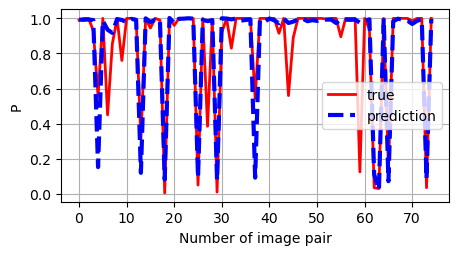

In [26]:
# --- Variant 1 (draw only part of points)---
nFirst = 75
# plt.figure(figsize = (7,3.8))
fig = plt.figure(figsize = (5,2.5))
ax = fig.add_subplot(111)
ax.plot(test_y_targ.values[:nFirst],'r', label='true',
          linewidth=2)
# plt.plot(crlb_.values[:nFirst],'b', label='CRLB_')
# plt.plot(kybic.values[:nFirst],'b', label='Kybic')
ax.plot(test_preds[:nFirst],'b--', label='prediction',
          linewidth=3)
# ---------------


# --- Variant 2 ---
# plt.plot(test_y_targ.values,'r', label='true')
# # plt.plot(crlb_.values,'m', label='CRLB_')
# plt.plot(kybic.values,'k', label='Kybic')
# plt.plot(test_preds,'b', label='newML')
# ---------------

plt.grid()
plt.legend(fontsize=10)
plt.xlabel('Number of image pair',size =10)
if select_par == 'x':
    plt.ylabel('RMSE for X axis',size =10)
elif select_par == 'y':
    plt.ylabel('RMSE for Y axis',size =10)
elif select_par == 'sc':
    plt.ylabel('RMSE for scale coef',size =10)
elif select_par == 'rot':
    plt.ylabel('RMSE for rotation coef',size =10)
elif select_par == 'P':
    plt.ylabel('P',size =10)
else:
    raise ValueError('Wrong select_par value')

In [27]:
#%% --- Plots for train predictions (DEBUG) ---
# plt.figure()
# plt.title('Performance on the train set')
# plt.plot(y_targ.values,'r', label='true')
# plt.plot(preds,'b', label='newML')
# plt.legend(fontsize=10)


# **Neaural network**

In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# import torchvision.transforms.v2 as T2
import torchvision.transforms as T

import random 

In [29]:
# - - - Fixing randomness

random.seed(13) 
np.random.seed(13)
torch.manual_seed(13)

In [30]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


import image data

In [31]:
import pickle

file = open('/kaggle/input/im-registration-accur-estimation/train__ci_ri_list__4980p.pkl', 'rb')
train__ci_ri_list = pickle.load(file)
file.close()

file = open('/kaggle/input/im-registration-accur-estimation/test__ci_ri_list__879p.pkl', 'rb')
test__ci_ri_list = pickle.load(file)
file.close()



file = open('/kaggle/input/im-registration-accur-estimation/valid__ci_ri_list__1996p.pkl', 'rb')
valid__ci_ri_list = pickle.load(file)
file.close()

In [32]:
# if "ci_ri_list" contain None - fixed in last version of data_praparation file
train__ci_ri_list = [el for el in train__ci_ri_list if el is not None]
test__ci_ri_list = [el for el in test__ci_ri_list if el is not None]

valid__ci_ri_list = [el for el in valid__ci_ri_list if el is not None]

In [33]:
print(len(train__ci_ri_list))
print(len(test__ci_ri_list))
print(len(valid__ci_ri_list))
print()
# print(train__ci_ri_list[0])

4980
879
1996



In [34]:
print(indexces_train[:20])
print(indexces_test[:20])

print(indexces_valid[:20])

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')
RangeIndex(start=0, stop=20, step=1)
RangeIndex(start=0, stop=20, step=1)


In [35]:
train__ci_ri_list = [train__ci_ri_list[i] for i in indexces_train]
test__ci_ri_list = [test__ci_ri_list[i] for i in indexces_test]

valid__ci_ri_list = [valid__ci_ri_list[i] for i in indexces_valid]

In [36]:
# Check that length coinside
print(len(train__ci_ri_list))
print(len(test__ci_ri_list))
print(len(valid__ci_ri_list))
print()

print(len(X))
print(len(test_X))
print(len(valid_X))
print()

4978
879
1996

4978
879
1996



In [37]:
train__ci_ri_list[0]

array([[35.35164565, 36.36828718, 36.97784173, ..., 41.24888344,
        42.88279882, 38.05527984],
       [39.3355632 , 37.79932095, 29.9002657 , ..., 44.98437892,
        44.87524729, 40.28358846],
       [34.84754711, 35.23068084, 31.82702851, ..., 38.00206614,
        42.3264759 , 41.39821121],
       ...,
       [34.2061236 , 36.06831201, 23.98766971, ..., 28.96545902,
        28.76931395, 43.7453916 ],
       [28.14348106, 35.52569626, 25.93762963, ..., 29.43026273,
        41.64573006, 40.47823763],
       [31.96989373, 36.68240459, 25.78737738, ..., 40.52457735,
        39.46961554, 41.39506599]])

# Dataset

In [38]:

aug_train = T.Compose([ToTensor(),
                      T.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scale=(0.9, 1.1), 
                                     interpolation=T.InterpolationMode.BILINEAR)]
                  )
no_aug_test = ToTensor()
'''
print()
'''

'\nprint()\n'

In [39]:
im_size = 60   # 60, 128  , 120                                       # Attention

class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(X, y, ci_ri_list)
    ci_ri_list - list of Hx2H images
    len(X)==len(ci_ri_list)
    
    
    img, feat, y = dataset[i]
      img :     image (2xHxH)
      features : array og features
      y :    regression target (RMSE_x, RMSE_y, RMSE_scale, RMSE_rot, P, ...)
          (for 'test data' you can give random y array)
    """
    
    def __init__(self, X, y, ci_ri_list, mode=None):
        self.X = X
        self.y = y
        self.ci_ri_list = ci_ri_list
        self.mode = mode                    # 'train' or None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        ci_ri = self.ci_ri_list[i]
        n,m = ci_ri.shape
        # print('n,m = ', n,m),  # m=2*n
        
        ci = ci_ri[:, :n]
        ri_fragm = ci_ri[:, n:]
        
        
        dim = (im_size, im_size)
        ci_ = cv2.resize(ci, dim, interpolation = cv2.INTER_CUBIC)
        ri_fragm_ = cv2.resize(ri_fragm, dim, interpolation = cv2.INTER_CUBIC)
        
        
        img = np.zeros( (im_size,im_size,2) )   # H,W, C
        img[:,:,0] = ci_
        img[:,:,1] = ri_fragm_
        
        img = img/255.0
        
        if self.mode == 'train':   # transformation
            img = aug_train(img)   # C,H,W
        else:
            img = no_aug_test(img)
        
        # features = self.X.iloc[i,:]
        features = self.X.iloc[i,:].values
        
        y = self.y.iloc[i]
        # y = np.float64(self.y.iloc[i])
        
        return img.float(), torch.tensor(features).float(), torch.tensor(y).float() 

In [40]:
# ----------------------
if select_par == 'x':
    y_targ = y_targ   *  targ_norm_coef
elif select_par == 'y':
    y_targ = y_targ   *  targ_norm_coef
elif select_par == 'sc':
    y_targ = y_targ  *  targ_norm_coef*add_norm_for_sc
elif select_par == 'rot':
    y_targ = y_targ  *  targ_norm_coef
elif select_par == 'P':
    y_targ = y_targ
else:
    raise ValueError('Wrong select_par value')
# ----------------------


print('y_targ = ', y_targ[:10])

y_targ =  0    1.000
1    0.995
2    0.870
3    1.000
4    0.315
5    0.035
6    0.995
7    1.000
8    0.000
9    0.000
Name: P__ncc, dtype: float64


In [41]:
train_dataset = Dataset(X, y_targ, train__ci_ri_list, mode='train')           # Perform augmentations on samples
# train_dataset = Dataset(X, y_targ, train__ci_ri_list, mode=None)           # Perform augmentations on batches (modified model)

test_dataset = Dataset(test_X, test_y_targ, test__ci_ri_list, mode=None)

valid_dataset = Dataset(valid_X, valid_y_targ, valid__ci_ri_list, mode=None)

img =  tensor([[[0.1677, 0.1684, 0.1849,  ..., 0.1848, 0.2303, 0.2637],
         [0.1591, 0.1664, 0.1905,  ..., 0.2050, 0.2457, 0.2713],
         [0.1715, 0.1843, 0.1916,  ..., 0.2043, 0.2416, 0.2726],
         ...,
         [0.1816, 0.1995, 0.1879,  ..., 0.3006, 0.3009, 0.2752],
         [0.1875, 0.2027, 0.1908,  ..., 0.2945, 0.2981, 0.3146],
         [0.1836, 0.1980, 0.1670,  ..., 0.2415, 0.2502, 0.2907]],

        [[0.1585, 0.1721, 0.1899,  ..., 0.1813, 0.2341, 0.2667],
         [0.1602, 0.1672, 0.1893,  ..., 0.1986, 0.2474, 0.2779],
         [0.1693, 0.1848, 0.1947,  ..., 0.2012, 0.2459, 0.2691],
         ...,
         [0.1790, 0.1984, 0.1881,  ..., 0.3024, 0.2994, 0.2705],
         [0.1892, 0.2081, 0.1928,  ..., 0.3003, 0.3048, 0.3128],
         [0.1810, 0.2149, 0.1762,  ..., 0.2381, 0.2378, 0.2967]]])
feat =  tensor([ 1.0000, 49.0000,  1.2023, 79.9304,  5.2435,  5.1183,  0.1740,  0.1865])
y =  tensor(1.)


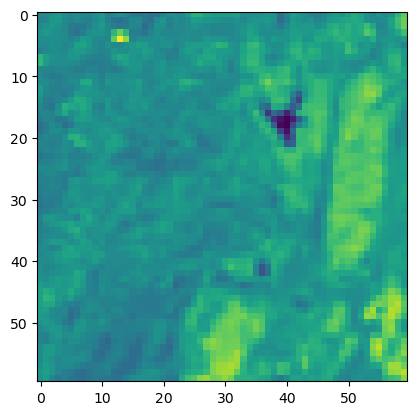

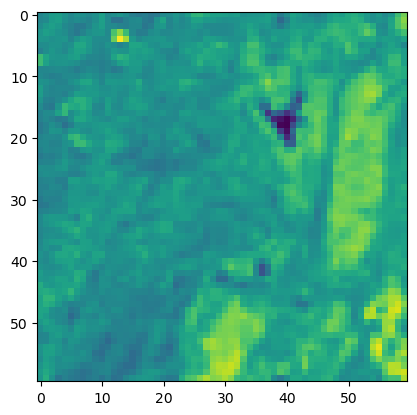

In [42]:
# --- Examine dataset class
ind = 5
'''
img, feat, y = train_dataset[ind]

print('img = ', img)
print('feat = ', feat)
print('y = ', y)
'''
img, feat, y = test_dataset[ind]

print('img = ', img)
print('feat = ', feat)
print('y = ', y)

plt.figure()
plt.imshow(img[0,:,:])
plt.figure()
plt.imshow(img[1,:,:])

# Dataloader

In [43]:
# the code from the example is partially used
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

batch_size = 64            # 64  , 128,  256   ,  512  , 1024                                                         # Attention
valid_bs = 2*4096

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              drop_last=True, shuffle=True,
                              num_workers=2)                                   # Attention


test_dataloader = DataLoader(test_dataset, batch_size=valid_bs,
                             drop_last=False, shuffle=False,
                             num_workers=2)

valid_dataloader = DataLoader(valid_dataset, batch_size=valid_bs,
                             drop_last=False, shuffle=False,
                             num_workers=2)

# --- DEBUG
for img, feat, y in train_dataloader:
    print(f"Shape of img [N, C, H, W]: {img.shape}")
    print(f"Shape of feat [N, C, H, W]: {feat.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of img [N, C, H, W]: torch.Size([64, 2, 60, 60])
Shape of feat [N, C, H, W]: torch.Size([64, 8])
Shape of y: torch.Size([64]) torch.float32


In [44]:
train_dataset_no_aug = Dataset(X, y_targ, train__ci_ri_list, mode=None)  
train_dataloader_no_aug = DataLoader(train_dataset_no_aug, batch_size=valid_bs,
                              drop_last=False, shuffle=False,
                              num_workers=2)

# Model

In [45]:
mode = 'cnn_with_features'   #  'cnn_with_features', 'cnn_10' , 'cnn_32'
attention_mode = True    # only for 'cnn_with_features', 'cnn_10'
normFeat_mode = True     # only for 'cnn_with_features' (norm before concat conv[or attention] and hand-made features), 
                         #          'cnn_10'  (norm before concat attention in and out,        work when attention_mode = True)

CNN_3

In [46]:

if mode == 'cnn_10': 
    class cnn(nn.Module):
        def __init__(self):
            super().__init__()

            self.transf = T.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scale=(0.9, 1.1), 
                                         interpolation=T.InterpolationMode.BILINEAR)

            self.conv_stack = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3),   # 58x58
                nn.BatchNorm2d(4, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3),   # 56x56
                nn.BatchNorm2d(4, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 28x28
                

                nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3),   # 26x26
                nn.BatchNorm2d(6, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3),   # 24x24
                nn.BatchNorm2d(6, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 12x12
                

                nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3),   # 10x10
                nn.BatchNorm2d(8, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),   # 8x8
                nn.BatchNorm2d(8, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 4x4

                
                nn.Conv2d(in_channels=8, out_channels=10, kernel_size=3),   # 2x2
                nn.BatchNorm2d(10, affine=True),
                nn.ReLU()
            )

            
            n_conv_feat = 10*2*2     # 10*2*2, 810 , 20*2*2                                # Attention
            # self.norm_on_batch = nn.BatchNorm1d(num_features=n_conv_feat)
            self.norm_on_batch = nn.BatchNorm1d(num_features=int(n_conv_feat/2))    # if concat with attention case 
            
            self.norm_on_channel = nn.LayerNorm(normalized_shape=10)  # only on channels 
            
            self.dense_stack = nn.Sequential(
                nn.Linear(n_conv_feat, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )
            
            num_heads = 5
            embed_dim = 10
            self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
            

        def forward(self, x):

            '''
            # - - IF augmentation in batch                                   # Attention
            if self.training:
                x = self.transf(x)
            '''
            
            
            conv_feat = self.conv_stack(x)      # N C H W   (N-batch,  C- channels, H-height, W-width)
            
            
            
            # - - - - - - With attention
            if attention_mode:
                # print('conv_feat.shape = ', conv_feat.shape)
                conv_feat = conv_feat.flatten(2, 3)     # N C S   (S-sequence)
                
                conv_feat_ = conv_feat.permute(2,0,1)    # S N C
                # --- 1st self-attention 
                attn_output, attn_output_weights = self.multihead_attn(query=conv_feat_, 
                                                                       key=conv_feat_, 
                                                                       value=conv_feat_)     # attn_output    # S N C
                '''
                attn_output, attn_output_weights = self.multihead_attn(query=attn_output, 
                                                                       key=attn_output, 
                                                                       value=attn_output)     # attn_output    # S N C
                '''
                
                attn_output_ = attn_output.permute(1,2,0)    # N C S
                
                
                # - - - - - - Norm before concat (in and out of attention)
                if normFeat_mode:
                    # --  Norm on batch
                    '''
                    conv_feat = conv_feat.flatten(1, -1)     # N F    (F-features)
                    conv_feat = self.norm_on_batch(conv_feat)
                    attn_output_ = attn_output_.flatten(1, -1)     # N F    (F-features)
                    attn_output_ = self.norm_on_batch(attn_output_)
                    '''
                    # --  Norm on channel (only attention out)
                    attn_output_ = attn_output_.permute(0,2,1)    # N S C
                    attn_output_ = self.norm_on_channel(attn_output_)   # Norm on C (last dimension) only
                    attn_output_ = attn_output_.permute(0,2,1)    # N C S
                # - - - - - - - -- - - - - - - -- - - - - -- - 
                
                
                
                # conv_feat = attn_output_                  # only attn_output
                # conv_feat = conv_feat + attn_output_        # add attn_output with input      # N C S
                conv_feat = torch.cat((conv_feat, attn_output_), dim=1)         #       # N 2*C S
            # - - - - - - - -- - - - - - - -- - - - - -- - 
            
            
            conv_feat = conv_feat.flatten(1, -1)     # N F    (F-features)
            
            
            logits = self.dense_stack(conv_feat)
            return logits

In [47]:
if mode == 'cnn_32': 
    class cnn(nn.Module):
        def __init__(self):
            super().__init__()

            self.transf = T.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scale=(0.9, 1.1), 
                                         interpolation=T.InterpolationMode.BILINEAR)

            n_conv_feat = 2592     # 32*2*2,  2592
            self.cnn_stack = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3),   # 58x58
                nn.BatchNorm2d(8, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),   # 56x56
                nn.BatchNorm2d(8, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 28x28
                

                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),   # 26x26
                nn.BatchNorm2d(16, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),   # 24x24
                nn.BatchNorm2d(16, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 12x12
                

                nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3),   # 10x10
                nn.BatchNorm2d(24, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3),   # 8x8
                nn.BatchNorm2d(24, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 4x4

                
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3),   # 2x2
                nn.BatchNorm2d(32, affine=True),
                nn.ReLU(),

                
                nn.Flatten(),
                nn.Linear(n_conv_feat, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )

        def forward(self, x):

            '''
            
            # - - IF augmentation in batch                                   # Attention
            if self.training:
                x = self.transf(x)
            '''
            
            
            
            logits = self.cnn_stack(x)
            return logits


# Combine cnn+features

In [48]:
# train_metric[-1] =  0.3254600726401089
# test_metric[-1] =  0.25901960194265294   'rot'

n_feat = len(features)   # 17, 8

if mode == 'cnn_with_features':  
    print("       'cnn_with_features' is used")

    class cnn(nn.Module):
        def __init__(self):
            super().__init__()
            self.transf = T.RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scale=(0.9, 1.1), 
                                         interpolation=T.InterpolationMode.BILINEAR)

            self.conv_stack = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3),   # 58x58
                nn.BatchNorm2d(4, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3),   # 56x56
                nn.BatchNorm2d(4, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 28x28

                nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3),   # 26x26
                nn.BatchNorm2d(6, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3),   # 24x24
                nn.BatchNorm2d(6, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 12x12

                nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3),   # 10x10
                nn.BatchNorm2d(8, affine=True),
                nn.ReLU(),
                nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),   # 8x8
                nn.BatchNorm2d(8, affine=True),
                nn.ReLU(),
                nn.MaxPool2d(2),                                           # 4x4
                
                nn.Conv2d(in_channels=8, out_channels=10, kernel_size=3),   # 2x2
                nn.BatchNorm2d(10, affine=True),
                nn.ReLU()
            )
            
            # self.flat = nn.Flatten()
            
            n_conv_feat = 10*2*2     # 10*2*2,  20*2*2
            self.norm_on_batch = nn.BatchNorm1d(num_features=n_conv_feat)
            # self.norm_on_batch = nn.BatchNorm1d(num_features=int(n_conv_feat/2))    # if concat with attention case
            
            self.norm_on_channel = nn.LayerNorm(normalized_shape=10)  # only on channels 
            
            
            
            self.feat_norm = nn.BatchNorm1d(n_feat)
            
            self.dense_stack = nn.Sequential(
                nn.Linear(n_conv_feat + n_feat, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )
            
            num_heads = 5
            embed_dim = 10
            self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
            


        def forward(self, img, feat):
            '''
            # - - IF augmentation in batch                                   # Attention
            if self.training:
                img = self.transf(img)
                # plt.figure()
                # plt.imshow(x[0,0,:,:].detach().cpu().numpy())
            '''

            conv_feat = self.conv_stack(img)    # N C H W   (N-batch,  C- channels, H-height, W-width)
            
            # - - - - - - With attention
            if attention_mode:
                conv_feat = conv_feat.flatten(2, 3)     # N C S   (S-sequence)
                conv_feat_ = conv_feat.permute(2,0,1)    # S N C
                # --- 1st self-attention 
                attn_output, attn_output_weights = self.multihead_attn(query=conv_feat_, 
                                                                       key=conv_feat_, 
                                                                       value=conv_feat_)     # attn_output    # S N C
                '''
                attn_output, attn_output_weights = self.multihead_attn(query=attn_output, 
                                                                       key=attn_output, 
                                                                       value=attn_output)     # attn_output    # S N C
                '''
                attn_output_ = attn_output.permute(1,2,0)    # N C S

                # - - - - - - Norm out of attention
                if normFeat_mode:
                    # - - --  Norm on batch
                    '''
                    # conv_feat = conv_feat.flatten(1, -1)     # N F    (F-features)
                    # conv_feat = self.norm_on_batch(conv_feat)
                    attn_output_ = attn_output_.flatten(1, -1)     # N F    (F-features)
                    attn_output_ = self.norm_on_batch(attn_output_)
                    '''
                    # --  Norm on channel (only attention out)
                    attn_output_ = attn_output_.permute(0,2,1)    # N S C
                    attn_output_ = self.norm_on_channel(attn_output_)   # Norm on C (last dimension) only
                    attn_output_ = attn_output_.permute(0,2,1)    # N C S
                    
                # - - - - - - - -- - - - - - - -- - - - - -- - 
                
                
                
                conv_feat = attn_output_                  # only attn_output
                # conv_feat = conv_feat + attn_output_        # add attn_output with input      # N C S
                # conv_feat = torch.cat((conv_feat, attn_output_), dim=1)         #       # N 2*C S
            # - - - - - - - -- - - - - - - -- - - - - -- - 
            
            
            conv_feat = conv_feat.flatten(1, -1)     # N F    (F-features)
            
            
            # - - - - - - With feat norm
            if normFeat_mode:
                if not attention_mode:
                    conv_feat = self.norm_on_batch(conv_feat)        # norm by batch

                feat = self.feat_norm(feat)         # N F    (F-features)
            # - - - - - - - -- - - - - - - -- - - - - -- - 
            
            x = torch.cat((conv_feat,feat), axis=1)    

            logits = self.dense_stack(x)
            return logits


       'cnn_with_features' is used


In [49]:
model = cnn().to(device)

In [50]:
from torchinfo import summary

if (mode == 'cnn_10') or (mode == 'cnn_32'): 
    print(
        summary(model, input_size=(batch_size, 2, im_size, im_size))
    )
elif mode == 'cnn_with_features': 
    print(
        summary(model, input_size=[(batch_size, 2, im_size, im_size), (batch_size,n_feat)] 
                )
    )

Layer (type:depth-idx)                   Output Shape              Param #
cnn                                      [64, 1]                   80
├─Sequential: 1-1                        [64, 10, 2, 2]            --
│    └─Conv2d: 2-1                       [64, 4, 58, 58]           76
│    └─BatchNorm2d: 2-2                  [64, 4, 58, 58]           8
│    └─ReLU: 2-3                         [64, 4, 58, 58]           --
│    └─Conv2d: 2-4                       [64, 4, 56, 56]           148
│    └─BatchNorm2d: 2-5                  [64, 4, 56, 56]           8
│    └─ReLU: 2-6                         [64, 4, 56, 56]           --
│    └─MaxPool2d: 2-7                    [64, 4, 28, 28]           --
│    └─Conv2d: 2-8                       [64, 6, 26, 26]           222
│    └─BatchNorm2d: 2-9                  [64, 6, 26, 26]           12
│    └─ReLU: 2-10                        [64, 6, 26, 26]           --
│    └─Conv2d: 2-11                      [64, 6, 24, 24]           330
│    └─BatchNo

# Optimizer

In [51]:
loss_fn = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)         # Attention
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 250   # 500,  250  , 100                                     # Attention
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=7e-4, steps_per_epoch=len(train_dataloader), epochs=epochs)

In [52]:
# model.to(torch.double)
print()

# Training

In [53]:
# the code from the example is partially used
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (img, feat, y) in enumerate(dataloader):
        img, feat, y = img.to(device), feat.to(device), y.to(device)

        # Compute prediction error
        if mode == 'cnn_with_features':
            pred = model(img, feat)
        elif (mode == 'cnn_10') or (mode == 'cnn_32'):
            pred = model(img)
        pred = torch.squeeze(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

In [54]:
# from torchmetrics.functional import r2_score as r2_torch     # strangely works for small values

def evaluate(dataloader, model, mode_='test'):
    model.eval()
    preds = torch.empty((0,), dtype=torch.float64).to(device)
    ys = torch.empty((0,), dtype=torch.float64).to(device)
    
    with torch.no_grad():
        for img, feat, y in dataloader:
            img, feat, y = img.to(device), feat.to(device), y.to(device)
            
            if mode == 'cnn_with_features':
                pred = model(img, feat)
            elif (mode == 'cnn_10') or (mode == 'cnn_32'):
                pred = model(img)
                
            pred = torch.squeeze(pred)
            preds = torch.cat((preds, pred))
            ys = torch.cat((ys, y))
    
    preds = preds.detach().cpu().numpy()
    ys = ys.detach().cpu().numpy()
    
    # - - - - - - - - - - -
    if select_par == 'sc':
        preds = preds / (targ_norm_coef*add_norm_for_sc)
        if mode_ == 'train':     # for train, target multiplied by constant (small value issue)
            ys = ys / (targ_norm_coef*add_norm_for_sc)
    elif (select_par == 'x') or (select_par == 'y') or (select_par == 'rot'):
        preds = preds / targ_norm_coef
        if mode_ == 'train':
            ys = ys / targ_norm_coef
    # - - - - - - - - - - -
    
    
    metric = r2_score(ys,preds)      # in sklean function: r2_score(true, pred)
    
    return metric, preds, ys


In [55]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 2, 60, 60])

In [56]:
best_metric = None
best_epoch = None

train_metric = []
valid_metric = []

t_start = time.time()
for t in range(epochs):
    # print(f"Epoch {t + 1}\n-------------------------------")
    
    
    train(train_dataloader, model, loss_fn, optimizer)
    '''
    metric_tr, preds_tr, ys_tr = evaluate(train_dataloader_no_aug, model, mode_='train')  # on train without aug
    train_metric.append(metric_tr)
    '''
    
    metric, preds, ys = evaluate(valid_dataloader, model)
    valid_metric.append(metric)
    
    
    if (best_metric is None) or (metric > best_metric):
        best_metric = metric
        # Save the model checkpoint
        torch.save(model.state_dict(), "/kaggle/working/best_model_checkpoint.pth")
        best_epoch = t
    
    
    
    if (t%40 == 0):
        # print(f"Epoch {t + 1}")
        # print(f"Epoch {t + 1},   train R2 = {train_metric[-1]},   valid R2 = {valid_metric[-1]}")
        print(f"Epoch {t + 1},   valid R2 = {valid_metric[-1]}")
        
        
        '''
        plt.figure()
        plt.title(f'On test, epoch = {t}')
        plt.plot(preds[:75], label='preds')
        plt.plot(ys[:75], label='ys')
        plt.legend()
        '''
        

Epoch 1,   valid R2 = -6.841568847351033
Epoch 41,   valid R2 = 0.7215764700957393
Epoch 81,   valid R2 = 0.7406620648928217
Epoch 121,   valid R2 = 0.737032072223149
Epoch 161,   valid R2 = 0.7487365944296115
Epoch 201,   valid R2 = 0.7471814763333355
Epoch 241,   valid R2 = 0.7470196530345263


In [57]:
elapsed = time.time() - t_start
print()
print('Time, s = ', elapsed,  '    Time, hours = ', elapsed / 3600)


Time, s =  1605.3253645896912     Time, hours =  0.44592371238602535


In [58]:
# - - - - Time of evaluate

'''

t_start = time.time()
metric_tr, preds_tr, ys_tr = evaluate(train_dataloader_no_aug, model, mode_='train')
elapsed = time.time() - t_start
print('Time, s = ', elapsed,  '    Time, hours = ', elapsed / 3600)

t_start = time.time()
metric, preds, ys = evaluate(valid_dataloader, model)
elapsed = time.time() - t_start
print('Time, s = ', elapsed,  '    Time, hours = ', elapsed / 3600)
'''
print()

# Train vs Test prediction

In [59]:
model = cnn().to(device)

checkpoint_path = "/kaggle/working/best_model_checkpoint.pth"  
model.load_state_dict(torch.load(checkpoint_path))

model.eval()

with torch.no_grad():
    metric_tr, preds_tr, ys_tr = evaluate(train_dataloader_no_aug, model, mode_='train')
    metric, preds, ys = evaluate(valid_dataloader, model)
    metric_test, preds_test, ys_test = evaluate(test_dataloader, model)

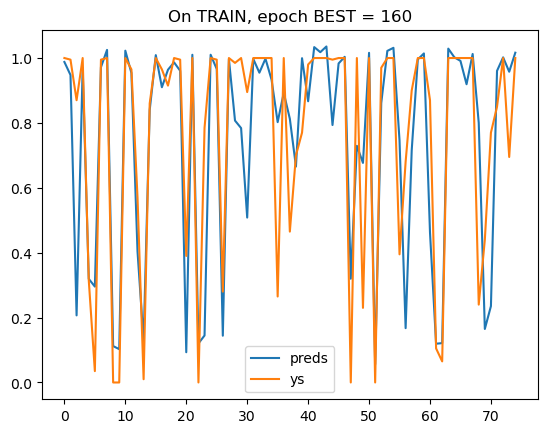

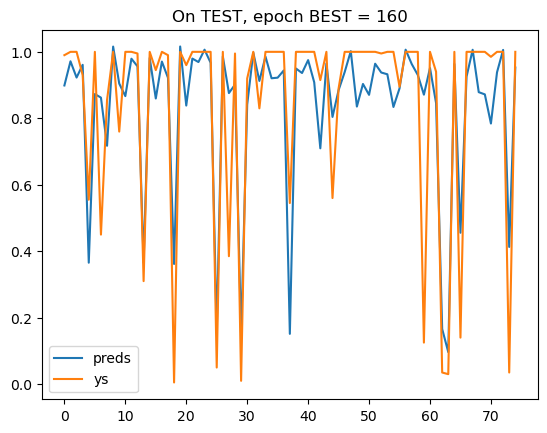

In [60]:
# After last epoch
n_preds = 75

plt.figure()
plt.title(f'On TRAIN, epoch BEST = {best_epoch+1}')
plt.plot(preds_tr[:n_preds], label='preds')
plt.plot(ys_tr[:n_preds], label='ys')
plt.legend()

plt.figure()
plt.title(f'On TEST, epoch BEST = {best_epoch+1}')
plt.plot(preds_test[:n_preds], label='preds')
plt.plot(ys_test[:n_preds], label='ys')
plt.legend()




In [61]:
# create figure for paper

'''
plt.figure(figsize = (5,1))
plt.plot(preds_test[:n_preds], label='prediction')
plt.plot(ys_test[:n_preds], label='true P')
plt.xlabel('image pair number')
plt.ylabel('P')
plt.legend()

plt.savefig('example.tiff', bbox_inches='tight')
'''
print()

# History of training

     - - best_epoch:  159
train BEST =  0.8025432423831926
test BEST =  0.6411396590313436


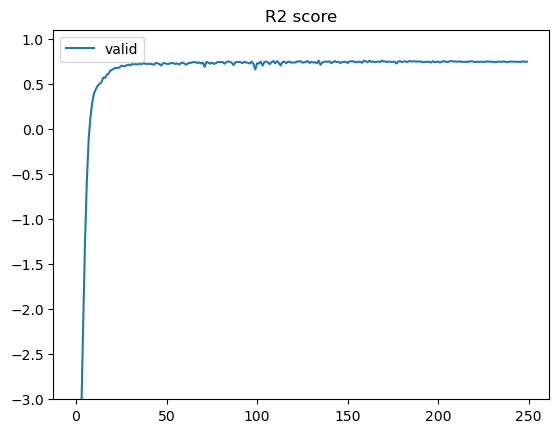

In [62]:
plt.figure()
plt.title('R2 score')
# plt.plot(train_metric[:], label='train')
plt.plot(valid_metric[:], label='valid')

plt.legend()
plt.ylim((-3, 1.1)) 

# print('train_metric[-1] = ', train_metric[-1])
# print('valid_metric[-1] = ', valid_metric[-1])


print('     - - best_epoch: ', best_epoch)
print('train BEST = ', metric_tr)
print('test BEST = ', metric_test)

In [63]:
'''
from_ = 400
to_ = 430
plt.figure()
plt.title('R2 score')
plt.plot(train_metric[from_:to_], label='train')
plt.plot(valid_metric[from_:to_], label='valid')

plt.legend()
plt.ylim((-3, 1.1)) 
'''
print()